<a href="https://colab.research.google.com/github/gagliotti/reach-analysis/blob/main/MuitaDorLivre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuração

In [2]:
import xarray as xr
import re
from pyomeca import Markers
import matplotlib.pyplot as plt
import numpy as np

import ezc3d

dir = './data'


In [3]:
#Funções utilitárias

#Define função que concatena arquivos c3d em um único arquivo c3d
def concatena(dir, subdir, lista) :
  # Corrected path by removing extra subdir
  #print(f'{dir}/{subdir}/{lista[0]}')
  markers1 = Markers.from_c3d(f'{dir}/{subdir}/{lista[0]}')
  ultimoTempo = markers1['time'][-1].values

  for i in lista[1::] :
    # Corrected path by removing extra subdir
    nextmarker = Markers.from_c3d(f'{dir}/{subdir}/{i}')
    nextmarker['time'] = nextmarker['time'] + ultimoTempo + 1/200
    markers1 = xr.concat([markers1, nextmarker], dim='time')
    ultimoTempo = markers1['time'].values[-1]

  return markers1

#Define funcao para gravar markers em arquivo c3d
def writeC3d(markers, dir, subdir, filename) :
    # Convert to NumPy
    markers_data = markers.values  # Already shaped as (4, markers, frames)

    # Debugging: Print actual shape
    print("Original markers_data shape:", markers_data.shape)

    # Ensure that the shape is (4, num_markers, num_frames)
    if markers_data.shape[0] != 4:
        raise ValueError(f"Unexpected markers_data shape: {markers_data.shape}. Expected (4, num_markers, num_frames)")

    # Extract dimensions
    _, num_markers, num_frames = markers_data.shape

    # Create a new empty C3D file
    c3d = ezc3d.c3d()

    # Set parameters
    c3d["parameters"]["POINT"]["USED"]["value"] = [num_markers]
    c3d["parameters"]["POINT"]["FRAMES"]["value"] = [num_frames]
    c3d["header"]["points"]["frame_number"] = num_frames

    # Directly assign `markers_data` since it is already in the correct shape
    c3d["data"]["points"] = markers_data

    # Save the new C3D file
    output_path = f"{dir}/{subdir}/{filename}.c3d"
    c3d.write(output_path)



# Define funcao que remove NaN
def retiraNaN(dados) :
  return dados[~np.isnan(dados)]

# Define funcao que calcula estatisticas
def calcular_estatisticas_sem_outliers(dados):
    Q1 = np.percentile(dados, 25)
    Q3 = np.percentile(dados, 75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    dados_sem_outliers = [x for x in dados if limite_inferior <= x <= limite_superior]

    return {
        "Média": np.mean(dados),
        "Mediana": np.median(dados),
        "Q1": Q1,
        "Q3": Q3,
        "Mínimo": min(dados_sem_outliers),  # Sem outliers
        "Máximo": max(dados_sem_outliers)   # Sem outliers
    }

In [4]:
#Define funcoes para concatenar arquivos e gravar no disco

def removeMarkers(markersToRemove, c3d) :
  labels = c3d["parameters"]["POINT"]["LABELS"]["value"]
  for removing in markersToRemove :
      idx = labels.index(removing)

      # Remove marker from the point data
      c3d["data"]["points"] = np.delete(c3d["data"]["points"], idx, axis=1)

      # Remove the label from POINT.LABELS
      labels.pop(idx)

  c3d["parameters"]["POINT"]["LABELS"]["value"] = labels

  # Update number of markers
  c3d["parameters"]["POINT"]["USED"]["value"] = [len(labels)]
  return c3d

def concatenate_c3d(dir, subdir, lista):

    c3d_1 = ezc3d.c3d(f'{dir}/{subdir}/{lista[0]}')

    frames = c3d_1["data"]["points"].shape[2]
    print(f'{lista[0]} inicial => {frames} frames')

    for i in lista[1::] :

        c3d_2 = ezc3d.c3d(f'{dir}/{subdir}/{i}')
        frames = c3d_2["data"]["points"].shape[2]
        print(f'{i} => {frames} frames')

        labels1 = set(c3d_1["parameters"]["POINT"]["LABELS"]["value"])
        labels2 = set(c3d_2["parameters"]["POINT"]["LABELS"]["value"])

        intersec = labels1 & labels2

        removeFromLabels1 = list( labels1 - intersec)
        removeFromLabels2 = list( labels2 - intersec)

        c3d_1 = removeMarkers(removeFromLabels1, c3d_1)
        c3d_2 = removeMarkers(removeFromLabels2, c3d_2)


        # Extract marker data (4, markers, frames)
        markers1 = c3d_1["data"]["points"]
        markers2 = c3d_2["data"]["points"]

        # Ensure both C3D files have the same number of markers
        if markers1.shape[1] != markers2.shape[1]:
            raise ValueError(f"Mismatch in number of markers: {dir}/{subdir}/{lista[0]} vs {dir}/{subdir}/{lista[i]}")

        # Concatenate along the time axis (frames)
        concatenated_markers = np.concatenate((markers1, markers2), axis=2)  # Shape: (4, markers, frames)

        # Create a new C3D file
        #c3d_new = ezc3d.c3d()
        num_markers = concatenated_markers.shape[1]
        num_frames = concatenated_markers.shape[2]

        c3d_1["data"]["points"] = concatenated_markers

        # Set parameters for the new C3D file
        c3d_1["parameters"]["POINT"]["USED"]["value"] = [num_markers]
        c3d_1["parameters"]["POINT"]["FRAMES"]["value"] = [num_frames]
        c3d_1["header"]["points"]["frame_number"] = num_frames
        c3d_1["parameters"]["TRIAL"]["ACTUAL_END_FIELD"]["value"] = [num_frames]

    if "meta_points" in c3d_1["data"]:
        del c3d_1["data"]["meta_points"]
    if "meta_analogs" in c3d_1["data"]:
        del c3d_1["data"]["meta_analogs"]

    # **Properly remove analog data**
    c3d_1["data"]["analogs"] = np.zeros((1, 0, num_frames))
    c3d_1["parameters"]["ANALOG"]["USED"]["value"] = [0]  # No analog channels
    c3d_1["parameters"]["ANALOG"]["LABELS"]["value"] = []  # No labels
    c3d_1["parameters"]["ANALOG"]["DESCRIPTIONS"]["value"] = []  # No descriptions
    c3d_1["parameters"]["ANALOG"]["SCALE"]["value"] = []  # No scale factors
    c3d_1["parameters"]["ANALOG"]["OFFSET"]["value"] = []  # No offsets
    c3d_1["parameters"]["ANALOG"]["GEN_SCALE"]["value"] = [1.0]  # Default scale
    c3d_1["parameters"]["ANALOG"]["RATE"]["value"] = [0]  # Set analog rate to zero

    frames = c3d_1["data"]["points"].shape[2]
    print(f'{lista[0]} final => {frames} frames')

    #pega o nome do arquivo (eg, bulleye de bulleye01.c3d)
    outputFilename = re.findall(r'([a-zA-Z ]*)', lista[0])[0]

    outputFilename = f'{outputFilename}-concat-'

    #pega o numero do arquivo (eg, 02 de bulleye02.c3d)
    for i in lista :
        numero = re.findall(r'\d+', i)[0]
        outputFilename = f'{outputFilename}{numero}'

    outputFilename = f'{dir}/{subdir}/{outputFilename}.c3d'

    # Save the new C3D file
    c3d_1.write(outputFilename)
    print(f"Concatenated C3D file saved as {outputFilename}")

# Definição de Arquivos C3D

In [5]:
# Arquivos para cada fase do jogo
# Pasta "muita dor livre"

subdir = 'muitadorlivre'

arquivosVagalumes = [ 'vagalumes01.c3d', 'vagalumes02.c3d']

arquivosSpacegunner = [
    "spacegunner01.c3d", "spacegunner02.c3d", "spacegunner03.c3d",
    "spacegunner04.c3d", "spacegunner05.c3d"
]



arquivosTubetrouble = [
    "tubetrouble-grupo11.c3d", "tubetrouble-grupo12.c3d", "tubetrouble-grupo13.c3d",
    "tubetrouble-grupo21.c3d", "tubetrouble-grupo22.c3d", "tubetrouble-grupo23.c3d"
]
arquivosBulleye = [
    #"bulleye01.c3d", #corrompido!
    "bulleye02.c3d",
    "bulleye03.c3d",
    "bulleye04.c3d",
    "bulleye05.c3d"
]
arquivosStarbeams = [
    "starbeams-grupo11.c3d",
    "starbeams-grupo12.c3d",
    "starbeams-grupo13.c3d",
    "starbeams-grupo21.c3d",
    "starbeams-grupo22.c3d",
    "starbeams-grupo23.c3d",
    "starbeams-grupo31.c3d",
    "starbeams-grupo32.c3d",
    "starbeams-grupo33.c3d"
]

In [6]:
#mudar executa para True SOMENTE qdo quiser gerar novamente os arquivos concatenados no disco
executa = False

if executa :
  concatenate_c3d(dir=dir, subdir=subdir, lista=arquivosVagalumes)
  concatenate_c3d(dir=dir, subdir=subdir, lista=arquivosSpacegunner)
  concatenate_c3d(dir=dir, subdir=subdir, lista=arquivosTubetrouble)
  concatenate_c3d(dir=dir, subdir=subdir, lista=arquivosBulleye)
  concatenate_c3d(dir=dir, subdir=subdir, lista=arquivosStarbeams)
  #files.download(f'vagalumes02030405.c3d')

In [7]:
# Concatena xarrays na memoria
vagalumesC3dsConcatenados = concatena(dir, subdir, arquivosVagalumes)
spacegunnerC3dsConcatenados = concatena(dir, subdir, arquivosSpacegunner)
tubetroubleC3dsConcatenados = concatena(dir, subdir, arquivosTubetrouble)
bulleyeC3dsConcatenados = concatena(dir, subdir, arquivosBulleye)
starbeamsC3dsConcatenados = concatena(dir, subdir, arquivosStarbeams)

C:\Users\gagli\AppData\Local\Temp\ipykernel_15760\247361961.py:14: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'channel' ('channel',) The recommendation is to set join explicitly for this case.
  markers1 = xr.concat([markers1, nextmarker], dim='time')
C:\Users\gagli\AppData\Local\Temp\ipykernel_15760\247361961.py:14: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'channel' ('channel',) The recommendation is to set join explicitly for this case.
  markers1 = xr.concat([markers1, nextmarker], dim='time')
C:\Users

In [8]:
#remove angulos errados

#spacegunner: remover intervalo [17.5,19.5]
spacegunnerC3dsConcatenados = spacegunnerC3dsConcatenados.where((spacegunnerC3dsConcatenados['time'] < 17.5) | (spacegunnerC3dsConcatenados['time']>19.5))


In [9]:
#limita o tempo de todos ao tempo da fase mais curta

limitar = True
#limitar = False

if limitar :
  todos = [vagalumesC3dsConcatenados, spacegunnerC3dsConcatenados, tubetroubleC3dsConcatenados, bulleyeC3dsConcatenados, starbeamsC3dsConcatenados]
  minimo = min(x['time'][-1] for x in todos)
  print(minimo)

  spacegunnerC3dsConcatenados = spacegunnerC3dsConcatenados.sel(time=slice(0,minimo))
  tubetroubleC3dsConcatenados = tubetroubleC3dsConcatenados.sel(time=slice(0,minimo))
  bulleyeC3dsConcatenados = bulleyeC3dsConcatenados.sel(time=slice(0,minimo))
  starbeamsC3dsConcatenados = starbeamsC3dsConcatenados.sel(time=slice(0,minimo))

  #no caso dos vagalumes, perde-se muito do vagalumes02.c3d.se se limitarmos a [0,minimo],
  #portanto peguei no meio da concatenacao
  meio = (vagalumesC3dsConcatenados['time'][-1])/2
  vagalumesC3dsConcatenados = vagalumesC3dsConcatenados.sel(time=slice(meio - minimo/2, meio + minimo/2))

  #ajusta vagalumes para começar em 0 e não em meio - minimo/2
  vagalumesC3dsConcatenados['time'] = np.arange(0,minimo + 1/200, 1/200)

<xarray.DataArray 'time' ()> Size: 8B
array(131.92)
Coordinates:
    time     float64 8B 131.9


In [10]:
#Seleciona angulos do ombro esquerdo
vagalumesAngulos = vagalumesC3dsConcatenados.sel(channel="LShoulderAngles")
spacegunnerAngulos = spacegunnerC3dsConcatenados.sel(channel="LShoulderAngles")
tubetroubleAngulos = tubetroubleC3dsConcatenados.sel(channel="LShoulderAngles")
bulleyeAngulos = bulleyeC3dsConcatenados.sel(channel="LShoulderAngles")
starbeamsAngulos = starbeamsC3dsConcatenados.sel(channel="LShoulderAngles")

# Eixo Y

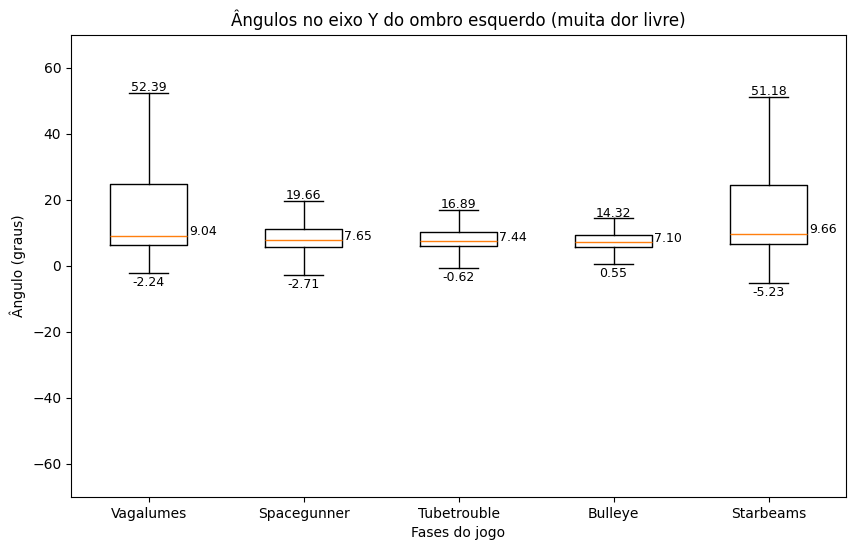

In [11]:
# Selecionar os ângulos do eixo Y
vagalumesAngulosFlat = vagalumesAngulos.sel(axis="y").values.flatten()
spacegunnerAngulosFlat = spacegunnerAngulos.sel(axis="y").values.flatten()
tubetroubleAngulosFlat = tubetroubleAngulos.sel(axis="y").values.flatten()
bulleyeAngulosFlat = bulleyeAngulos.sel(axis="y").values.flatten()
starbeamsAngulosFlat = starbeamsAngulos.sel(axis="y").values.flatten()

#Cria boxplots
vagalumesAngulosSemNaN = retiraNaN(vagalumesAngulosFlat)
spacegunnerAngulosSemNaN = retiraNaN(spacegunnerAngulosFlat)
tubetroubleAngulosSemNaN = retiraNaN(tubetroubleAngulosFlat)
bulleyAngulosSemNaN = retiraNaN(bulleyeAngulosFlat)
starbeamsAngulosSemNaN = retiraNaN(starbeamsAngulosFlat)

vagalumesEstatisticasAngulos = calcular_estatisticas_sem_outliers(vagalumesAngulosSemNaN)
spacegunnerEstatisticasAngulos = calcular_estatisticas_sem_outliers(spacegunnerAngulosSemNaN)
tubetroubleEstatisticasAngulos = calcular_estatisticas_sem_outliers(tubetroubleAngulosSemNaN)
bulleyeEstatisticasAngulos = calcular_estatisticas_sem_outliers(bulleyAngulosSemNaN)
starbeamsEstatisticasAngulos = calcular_estatisticas_sem_outliers(starbeamsAngulosSemNaN)


todosAngulosSemNaN = [vagalumesAngulosSemNaN, spacegunnerAngulosSemNaN, tubetroubleAngulosSemNaN, bulleyAngulosSemNaN, starbeamsAngulosSemNaN]
todosEstatisticasAngulos = [vagalumesEstatisticasAngulos, spacegunnerEstatisticasAngulos, tubetroubleEstatisticasAngulos, bulleyeEstatisticasAngulos, starbeamsEstatisticasAngulos]
todosNomesFases = ['Vagalumes', 'Spacegunner', 'Tubetrouble','Bulleye', 'Starbeams']

# Criar o boxplot sem exibir outliers
fig, ax = plt.subplots(figsize=(10, 6))
box = ax.boxplot(todosAngulosSemNaN, whis=1.5, showfliers=False, patch_artist=False, notch=False,)

# Ajustar rótulos do eixo X
ax.set_xticks(list(range(1,len(todosNomesFases)+1)))
ax.set_xticklabels(todosNomesFases)

# Ajustar os limites do eixo Y para incluir os bigodes corretos
#min_y = min(d["Mínimo"] for d in todosEstatisticasAngulos) - 2
#max_y = max(d["Máximo"] for d in todosEstatisticasAngulos) + 2
min_y = -70
max_y = 70

ax.set_ylim(min_y, max_y)

# Adicionar valores dentro do gráfico com deslocamento para a direita
deslocamento_x = 0.0 # Ajuste para mover as anotações para a direita
for i, stats in enumerate(todosEstatisticasAngulos, start=1):
    #ax.text(i + deslocamento_x, stats["Média"], f'Média: {stats["Média"]:.2f}', ha='left', fontsize=10, color='blue')
    ax.text(i + 0.35, stats["Mediana"] + 0.2, f'{stats["Mediana"]:.2f}', ha='center', fontsize=9, color='black')
    #ax.text(i + deslocamento_x, stats["Q1"]+.2, f'{stats["Q1"]:.2f}', ha='center', fontsize=9, color='black')
    #ax.text(i + deslocamento_x +.05, stats["Q3"]+.2, f'{stats["Q3"]:.2f}', ha='left', fontsize=9, color='black')
    ax.text(i + deslocamento_x, stats["Mínimo"] - 4, f'{stats["Mínimo"]:.2f}', ha='center', fontsize=9, color='black')  # Agora usa o whisker
    ax.text(i + deslocamento_x, stats["Máximo"] + 0.5, f'{stats["Máximo"]:.2f}', ha='center', fontsize=9, color='black')  # Agora usa o whisker

# Define título
plt.title("Ângulos no eixo Y do ombro esquerdo (muita dor livre)")
plt.ylabel("Ângulo (graus)")
plt.xlabel("Fases do jogo")
ax.yaxis.grid(False)

# Exibir gráfico
plt.show()


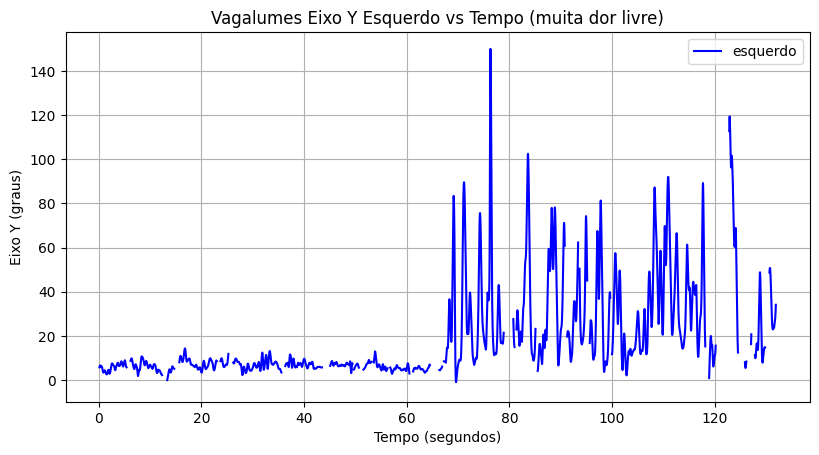

In [12]:
# plota vagalumes na linha do tempo

vagalumesAngulosYsemNaN = vagalumesAngulos.sel( axis="y")#.interpolate_na(dim="time", method="slinear")
#vagalumesAngulosYsemNaN_Right = vagalumesC3dsConcatenados.sel(channel="RShoulderAngles").sel( axis="y")

plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

vagalumesAngulosYsemNaN.plot(label='esquerdo', color='blue')
#vagalumesAngulosYsemNaN_Right.plot(label='direito', color='red')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo Y (graus)")
plt.title("Vagalumes Eixo Y Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

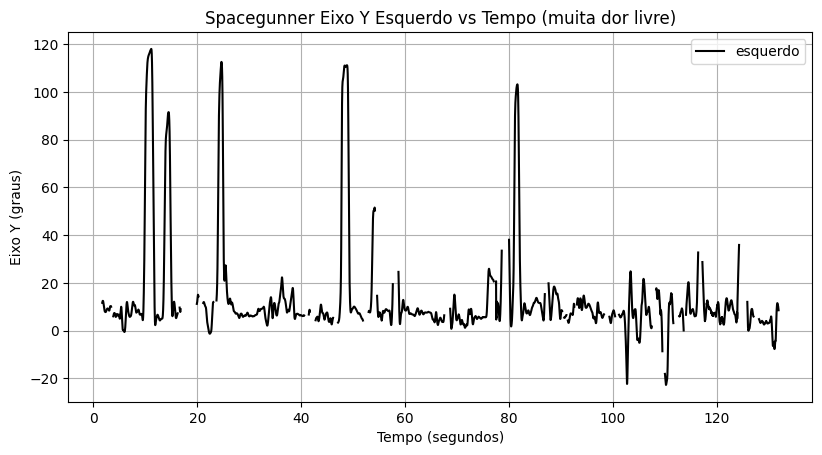

In [13]:
# plota spacegunner na linha do tempo

spacegunnerAngulosYsemNaN = spacegunnerC3dsConcatenados.sel(channel="LShoulderAngles").sel( axis="y")
spacegunnerAngulosYsemNaN = spacegunnerAngulosYsemNaN.where((spacegunnerAngulosYsemNaN['time'] < 17.5) | (spacegunnerAngulosYsemNaN['time'] > 19.5))

plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

spacegunnerAngulosYsemNaN.plot(label='esquerdo', color='black')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo Y (graus)")
plt.title("Spacegunner Eixo Y Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

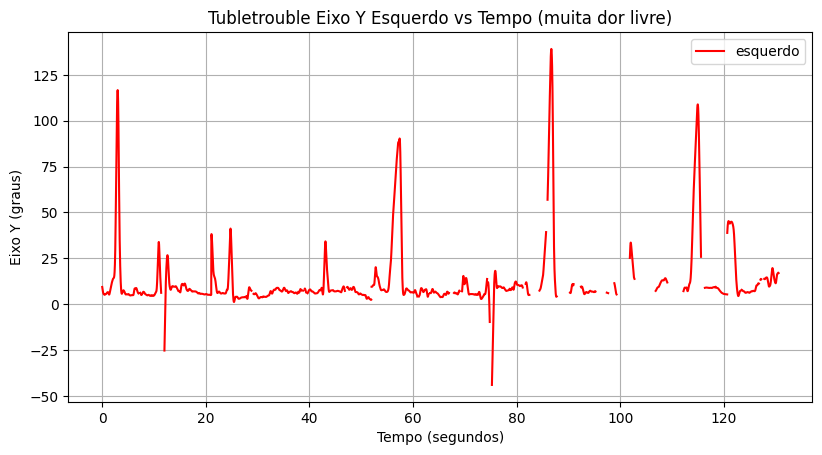

In [14]:
# plota tubetrouble na linha do tempo

tubetroubleAngulosYsemNaN = tubetroubleC3dsConcatenados.sel(channel="LShoulderAngles").sel( axis="y")

plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

tubetroubleAngulosYsemNaN.plot(label='esquerdo', color='red')
#tubetroubleAngulosYsemNaN_Right.plot(label='direito', color='red')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo Y (graus)")
plt.title("Tubletrouble Eixo Y Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

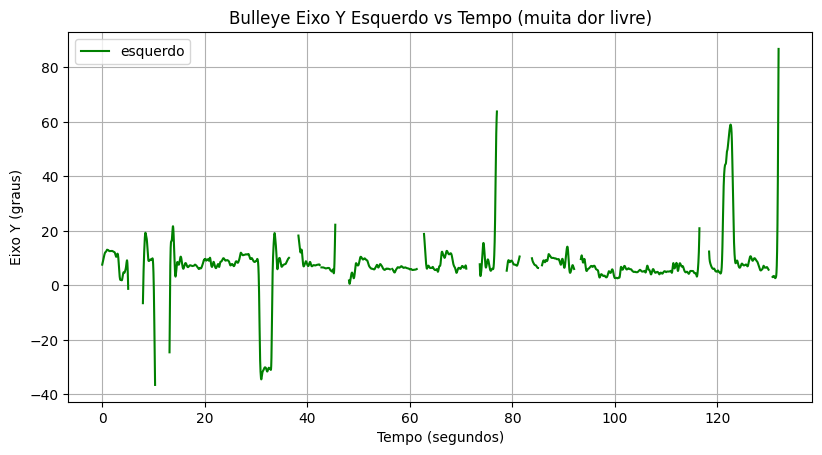

In [15]:
# plota bulleye na linha do tempo

bulleyeAngulosYsemNaN = bulleyeC3dsConcatenados.sel(channel="LShoulderAngles").sel( axis="y")

plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

bulleyeAngulosYsemNaN.plot(label='esquerdo', color='green')
#tubetroubleAngulosYsemNaN_Right.plot(label='direito', color='red')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo Y (graus)")
plt.title("Bulleye Eixo Y Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

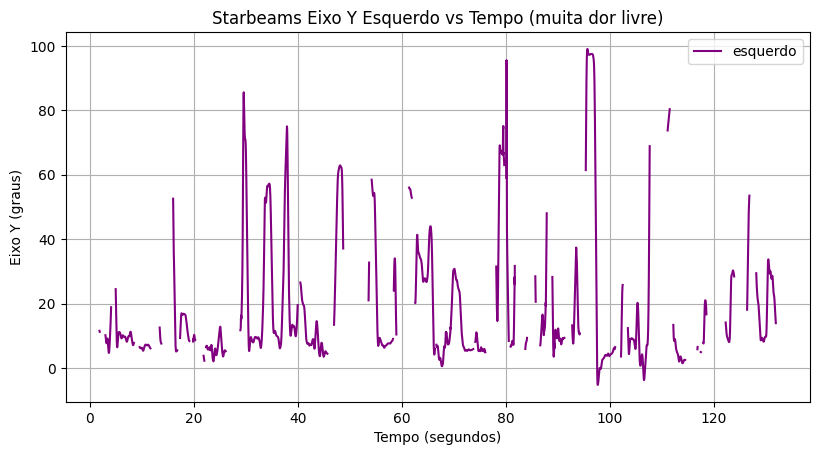

In [16]:
# plota bulleye na linha do tempo

starbeamsAngulosYsemNaN = starbeamsC3dsConcatenados.sel(channel="LShoulderAngles").sel( axis="y")

plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

starbeamsAngulosYsemNaN.plot(label='esquerdo', color='purple')
#tubetroubleAngulosYsemNaN_Right.plot(label='direito', color='red')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo Y (graus)")
plt.title("Starbeams Eixo Y Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

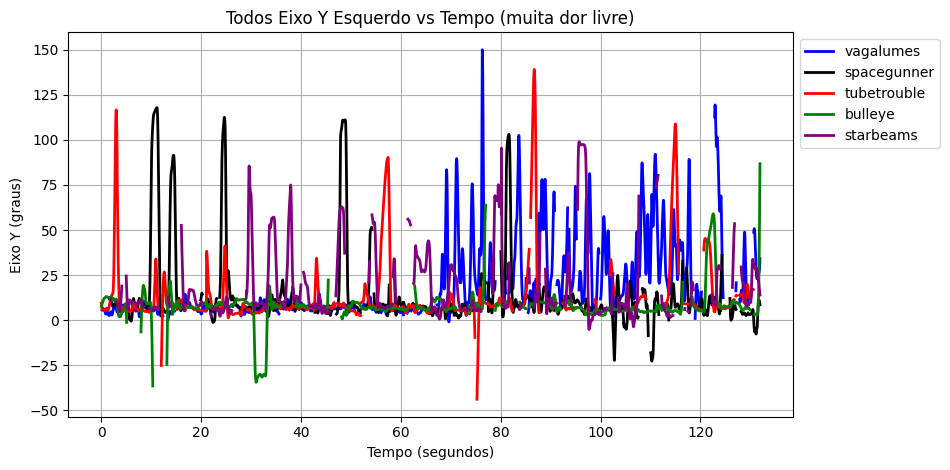

In [17]:
# plota todos na linha do tempo


plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

vagalumesAngulosYsemNaN.plot(label='vagalumes', color='blue', linewidth=2)
spacegunnerAngulosYsemNaN.plot(label='spacegunner', color='black', linewidth=2)
tubetroubleAngulosYsemNaN.plot(label='tubetrouble', color='red', linewidth=2)
bulleyeAngulosYsemNaN.plot(label='bulleye', color='green', linewidth=2)
starbeamsAngulosYsemNaN.plot(label='starbeams', color='purple', linewidth=2)
#tubetroubleAngulosYsemNaN_Right.plot(label='direito', color='red')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo Y (graus)")
plt.title("Todos Eixo Y Esquerdo vs Tempo (muita dor livre)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Move a legenda para fora
plt.tight_layout()  # Ajusta o layout automaticamente
plt.grid()
plt.show()

# Eixo X

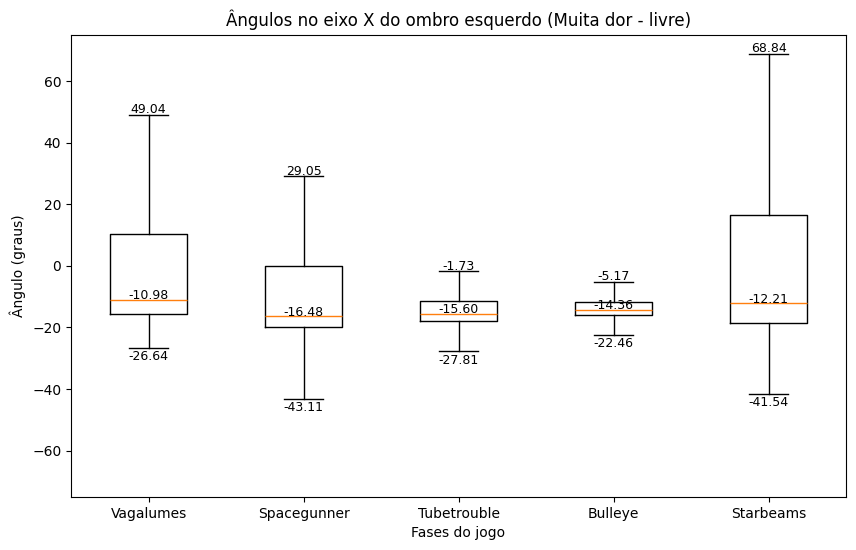

In [18]:
# Selecionar os ângulos do eixo X
vagalumesAngulosFlat = vagalumesAngulos.sel(axis="x").values.flatten()
spacegunnerAngulosFlat = spacegunnerAngulos.sel(axis="x").values.flatten()
tubetroubleAngulosFlat = tubetroubleAngulos.sel(axis="x").values.flatten()
bulleyeAngulosFlat = bulleyeAngulos.sel(axis="x").values.flatten()
starbeamsAngulosFlat = starbeamsAngulos.sel(axis="x").values.flatten()

#Cria boxplots
vagalumesAngulosSemNaN = retiraNaN(vagalumesAngulosFlat)
spacegunnerAngulosSemNaN = retiraNaN(spacegunnerAngulosFlat)
tubetroubleAngulosSemNaN = retiraNaN(tubetroubleAngulosFlat)
bulleyAngulosSemNaN = retiraNaN(bulleyeAngulosFlat)
starbeamsAngulosSemNaN = retiraNaN(starbeamsAngulosFlat)

vagalumesEstatisticasAngulos = calcular_estatisticas_sem_outliers(vagalumesAngulosSemNaN)
spacegunnerEstatisticasAngulos = calcular_estatisticas_sem_outliers(spacegunnerAngulosSemNaN)
tubetroubleEstatisticasAngulos = calcular_estatisticas_sem_outliers(tubetroubleAngulosSemNaN)
bulleyeEstatisticasAngulos = calcular_estatisticas_sem_outliers(bulleyAngulosSemNaN)
starbeamsEstatisticasAngulos = calcular_estatisticas_sem_outliers(starbeamsAngulosSemNaN)


todosAngulosSemNaN = [vagalumesAngulosSemNaN, spacegunnerAngulosSemNaN, tubetroubleAngulosSemNaN, bulleyAngulosSemNaN, starbeamsAngulosSemNaN]
todosEstatisticasAngulos = [vagalumesEstatisticasAngulos, spacegunnerEstatisticasAngulos, tubetroubleEstatisticasAngulos, bulleyeEstatisticasAngulos, starbeamsEstatisticasAngulos]
todosNomesFases = ['Vagalumes', 'Spacegunner', 'Tubetrouble','Bulleye', 'Starbeams']

# Criar o boxplot sem exibir outliers
fig, ax = plt.subplots(figsize=(10, 6))
box = ax.boxplot(todosAngulosSemNaN, whis=1.5, showfliers=False, patch_artist=False, notch=False,)

# Ajustar rótulos do eixo X
ax.set_xticks(list(range(1,len(todosNomesFases)+1)))
ax.set_xticklabels(todosNomesFases)

# Ajustar os limites do eixo Y para incluir os bigodes corretos
#min_y = min(d["Mínimo"] for d in todosEstatisticasAngulos) - 2
#max_y = max(d["Máximo"] for d in todosEstatisticasAngulos) + 2
min_y = -70
max_y = 70
ax.set_ylim(min_y, max_y)

# Adicionar valores dentro do gráfico com deslocamento para a direita
deslocamento_x = 0.0  # Ajuste para mover as anotações para a direita
for i, stats in enumerate(todosEstatisticasAngulos, start=1):
    #ax.text(i + deslocamento_x, stats["Média"], f'Média: {stats["Média"]:.2f}', ha='left', fontsize=10, color='blue')
    ax.text(i + deslocamento_x, stats["Mediana"] + 0.2, f'{stats["Mediana"]:.2f}', ha='center', fontsize=9, color='black')
    #ax.text(i + deslocamento_x, stats["Q1"]+.2, f'{stats["Q1"]:.2f}', ha='center', fontsize=9, color='black')
    #ax.text(i + deslocamento_x +.05, stats["Q3"]+.2, f'{stats["Q3"]:.2f}', ha='left', fontsize=9, color='black')
    ax.text(i + deslocamento_x, stats["Mínimo"] - 4, f'{stats["Mínimo"]:.2f}', ha='center', fontsize=9, color='black')  # Agora usa o whisker
    ax.text(i + deslocamento_x, stats["Máximo"] + 0.5, f'{stats["Máximo"]:.2f}', ha='center', fontsize=9, color='black')  # Agora usa o whisker

# Define título
plt.title("Ângulos no eixo X do ombro esquerdo (Muita dor - livre)")
plt.ylabel("Ângulo (graus)")
plt.xlabel("Fases do jogo")
ax.yaxis.grid(False)
ax.set_ylim(ax.get_ylim()[0] - 5, ax.get_ylim()[1] + 5)

# Exibir gráfico
plt.show()


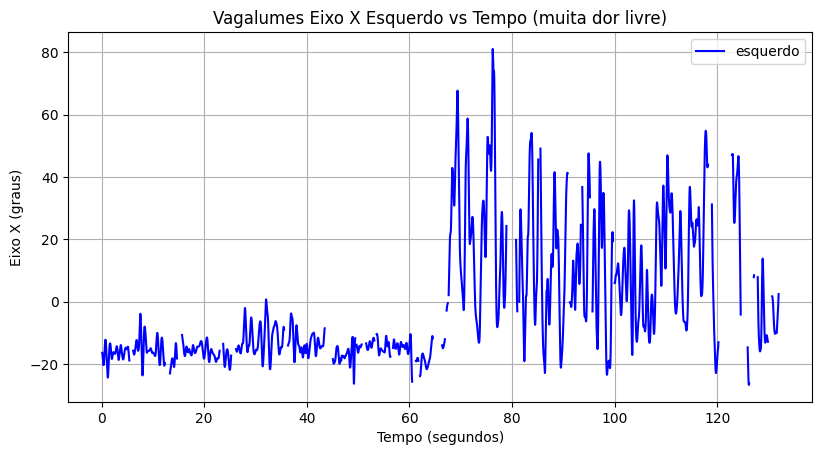

In [19]:
# plota vagalumes na linha do tempo

vagalumesAngulosXsemNaN = vagalumesAngulos.sel( axis="x")#.interpolate_na(dim="time", method="slinear")
#vagalumesAngulosYsemNaN_Right = vagalumesC3dsConcatenados.sel(channel="RShoulderAngles").sel( axis="y")

plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

vagalumesAngulosXsemNaN.plot(label='esquerdo', color='blue')
#vagalumesAngulosYsemNaN_Right.plot(label='direito', color='red')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo X (graus)")
plt.title("Vagalumes Eixo X Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

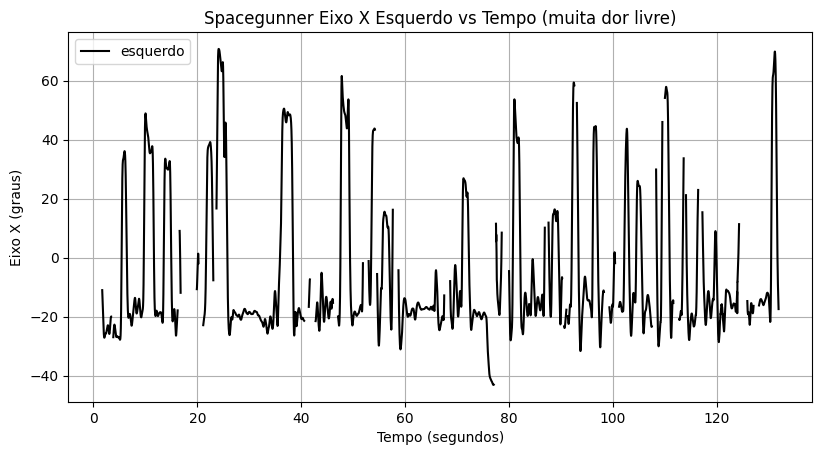

In [20]:
# plota spacegunner na linha do tempo

spacegunnerAngulosXsemNaN = spacegunnerC3dsConcatenados.sel(channel="LShoulderAngles").sel( axis="x")

plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

spacegunnerAngulosXsemNaN.plot(label='esquerdo', color='black')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo X (graus)")
plt.title("Spacegunner Eixo X Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

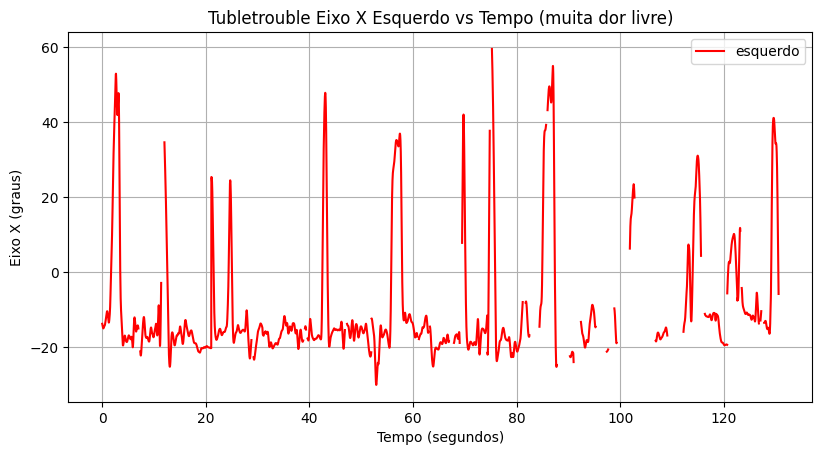

In [21]:
# plota tubetrouble na linha do tempo

tubetroubleAngulosXsemNaN = tubetroubleC3dsConcatenados.sel(channel="LShoulderAngles").sel( axis="x")

plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

tubetroubleAngulosXsemNaN.plot(label='esquerdo', color='red')
#tubetroubleAngulosYsemNaN_Right.plot(label='direito', color='red')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo X (graus)")
plt.title("Tubletrouble Eixo X Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

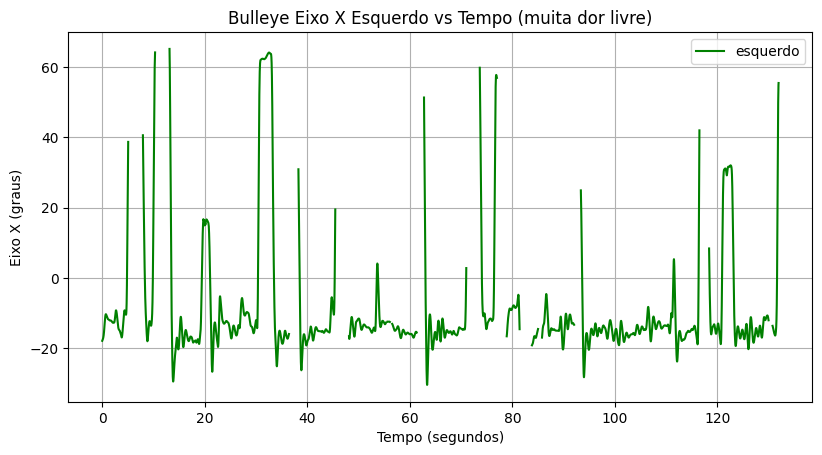

In [22]:
# plota bulleye na linha do tempo

bulleyeAngulosXsemNaN = bulleyeC3dsConcatenados.sel(channel="LShoulderAngles").sel(axis="x")

plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

bulleyeAngulosXsemNaN.plot(label='esquerdo', color='green')
#tubetroubleAngulosYsemNaN_Right.plot(label='direito', color='red')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo X (graus)")
plt.title("Bulleye Eixo X Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

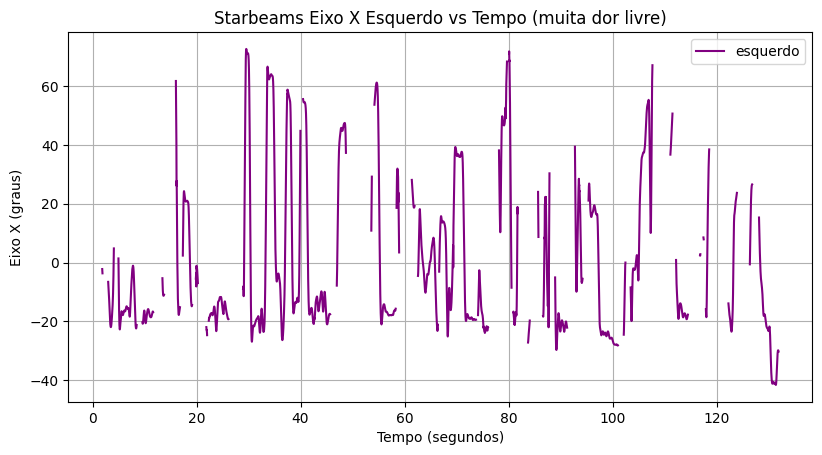

In [23]:
# plota bulleye na linha do tempo

starbeamsAngulosXsemNaN = starbeamsC3dsConcatenados.sel(channel="LShoulderAngles").sel( axis="x")

plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

starbeamsAngulosXsemNaN.plot(label='esquerdo', color='purple')
#tubetroubleAngulosYsemNaN_Right.plot(label='direito', color='red')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo X (graus)")
plt.title("Starbeams Eixo X Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

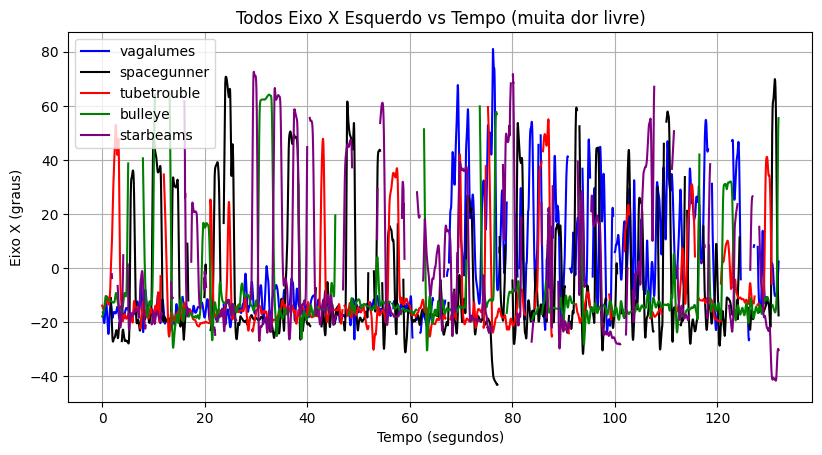

In [24]:
# plota todos na linha do tempo


plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

vagalumesAngulosXsemNaN.plot(label='vagalumes', color='blue')
spacegunnerAngulosXsemNaN.plot(label='spacegunner', color='black')
tubetroubleAngulosXsemNaN.plot(label='tubetrouble', color='red')
bulleyeAngulosXsemNaN.plot(label='bulleye', color='green')
starbeamsAngulosXsemNaN.plot(label='starbeams', color='purple')
#tubetroubleAngulosYsemNaN_Right.plot(label='direito', color='red')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo X (graus)")
plt.title("Todos Eixo X Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

# Eixo Z

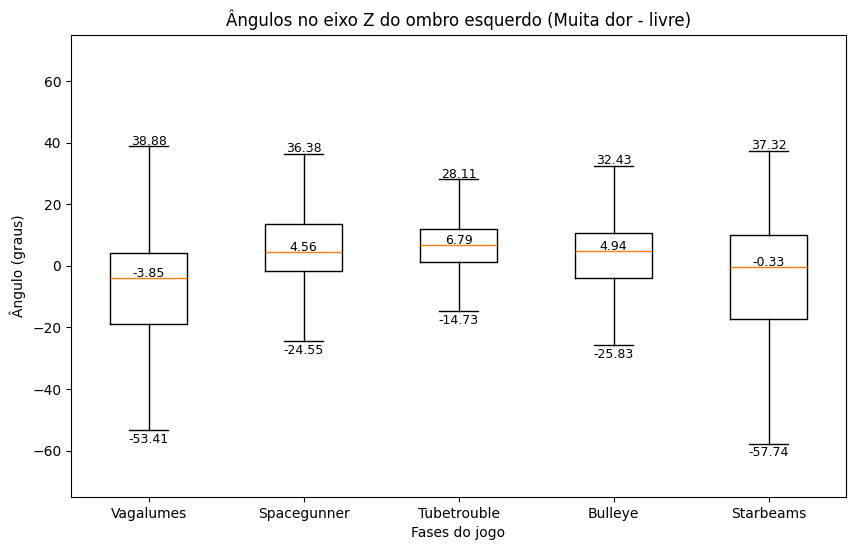

In [25]:
# Selecionar os ângulos do eixo Z
vagalumesAngulosFlat = vagalumesAngulos.sel(axis="z").values.flatten()
spacegunnerAngulosFlat = spacegunnerAngulos.sel(axis="z").values.flatten()
tubetroubleAngulosFlat = tubetroubleAngulos.sel(axis="z").values.flatten()
bulleyeAngulosFlat = bulleyeAngulos.sel(axis="z").values.flatten()
starbeamsAngulosFlat = starbeamsAngulos.sel(axis="z").values.flatten()

#Cria boxplots
vagalumesAngulosSemNaN = retiraNaN(vagalumesAngulosFlat)
spacegunnerAngulosSemNaN = retiraNaN(spacegunnerAngulosFlat)
tubetroubleAngulosSemNaN = retiraNaN(tubetroubleAngulosFlat)
bulleyAngulosSemNaN = retiraNaN(bulleyeAngulosFlat)
starbeamsAngulosSemNaN = retiraNaN(starbeamsAngulosFlat)

vagalumesEstatisticasAngulos = calcular_estatisticas_sem_outliers(vagalumesAngulosSemNaN)
spacegunnerEstatisticasAngulos = calcular_estatisticas_sem_outliers(spacegunnerAngulosSemNaN)
tubetroubleEstatisticasAngulos = calcular_estatisticas_sem_outliers(tubetroubleAngulosSemNaN)
bulleyeEstatisticasAngulos = calcular_estatisticas_sem_outliers(bulleyAngulosSemNaN)
starbeamsEstatisticasAngulos = calcular_estatisticas_sem_outliers(starbeamsAngulosSemNaN)


todosAngulosSemNaN = [vagalumesAngulosSemNaN, spacegunnerAngulosSemNaN, tubetroubleAngulosSemNaN, bulleyAngulosSemNaN, starbeamsAngulosSemNaN]
todosEstatisticasAngulos = [vagalumesEstatisticasAngulos, spacegunnerEstatisticasAngulos, tubetroubleEstatisticasAngulos, bulleyeEstatisticasAngulos, starbeamsEstatisticasAngulos]
todosNomesFases = ['Vagalumes', 'Spacegunner', 'Tubetrouble','Bulleye', 'Starbeams']

# Criar o boxplot sem exibir outliers
fig, ax = plt.subplots(figsize=(10, 6))
box = ax.boxplot(todosAngulosSemNaN, whis=1.5, showfliers=False, patch_artist=False, notch=False,)

# Ajustar rótulos do eixo X
ax.set_xticks(list(range(1,len(todosNomesFases)+1)))
ax.set_xticklabels(todosNomesFases)

# Ajustar os limites do eixo Y para incluir os bigodes corretos
#min_y = min(d["Mínimo"] for d in todosEstatisticasAngulos) - 2
#max_y = max(d["Máximo"] for d in todosEstatisticasAngulos) + 2
min_y = -70
max_y = 70
ax.set_ylim(min_y, max_y)

# Adicionar valores dentro do gráfico com deslocamento para a direita
deslocamento_x = 0.0  # Ajuste para mover as anotações para a direita
for i, stats in enumerate(todosEstatisticasAngulos, start=1):
    #ax.text(i + deslocamento_x, stats["Média"], f'Média: {stats["Média"]:.2f}', ha='left', fontsize=10, color='blue')
    ax.text(i + deslocamento_x, stats["Mediana"] + 0.2, f'{stats["Mediana"]:.2f}', ha='center', fontsize=9, color='black')
    #ax.text(i + deslocamento_x, stats["Q1"]+.2, f'{stats["Q1"]:.2f}', ha='center', fontsize=9, color='black')
    #ax.text(i + deslocamento_x +.05, stats["Q3"]+.2, f'{stats["Q3"]:.2f}', ha='left', fontsize=9, color='black')
    ax.text(i + deslocamento_x, stats["Mínimo"] - 4, f'{stats["Mínimo"]:.2f}', ha='center', fontsize=9, color='black')  # Agora usa o whisker
    ax.text(i + deslocamento_x, stats["Máximo"] + 0.5, f'{stats["Máximo"]:.2f}', ha='center', fontsize=9, color='black')  # Agora usa o whisker

# Define título
plt.title("Ângulos no eixo Z do ombro esquerdo (Muita dor - livre)")
plt.ylabel("Ângulo (graus)")
plt.xlabel("Fases do jogo")
ax.yaxis.grid(False)
ax.set_ylim(ax.get_ylim()[0] - 5, ax.get_ylim()[1] + 5)

# Exibir gráfico
plt.show()


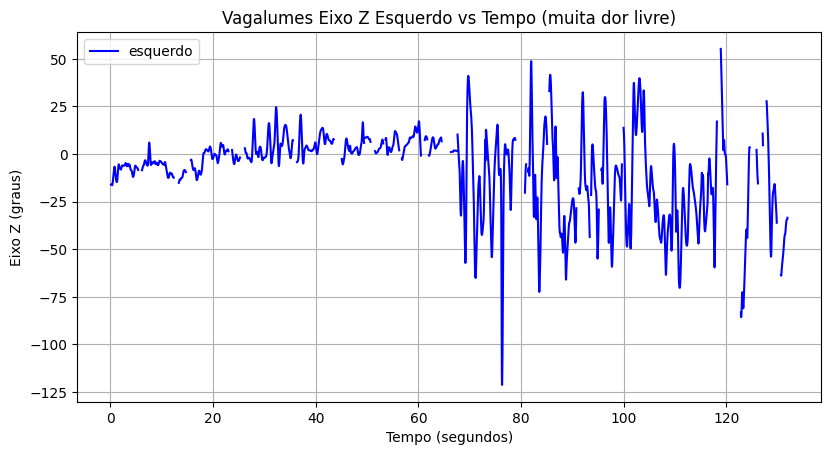

In [26]:
# plota vagalumes na linha do tempo

vagalumesAngulosZsemNaN = vagalumesAngulos.sel( axis="z")#.interpolate_na(dim="time", method="slinear")
#vagalumesAngulosYsemNaN_Right = vagalumesC3dsConcatenados.sel(channel="RShoulderAngles").sel( axis="y")

plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

vagalumesAngulosZsemNaN.plot(label='esquerdo', color='blue')
#vagalumesAngulosYsemNaN_Right.plot(label='direito', color='red')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo Z (graus)")
plt.title("Vagalumes Eixo Z Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

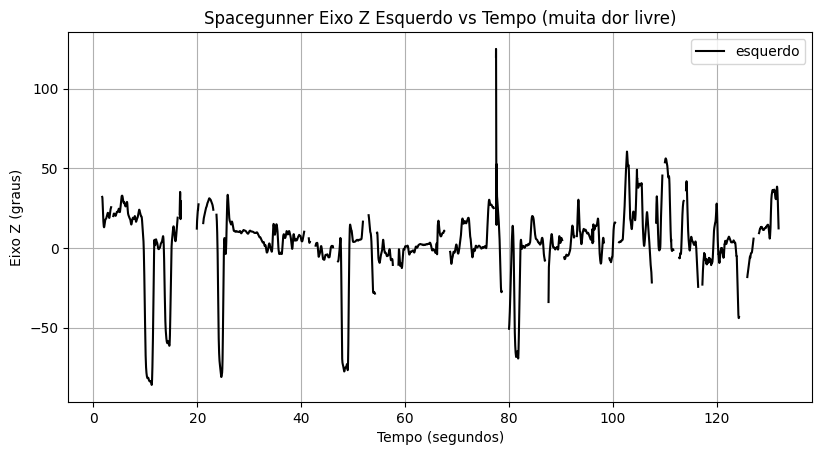

In [27]:
# plota spacegunner na linha do tempo

spacegunnerAngulosZsemNaN = spacegunnerC3dsConcatenados.sel(channel="LShoulderAngles").sel( axis="z")

plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

spacegunnerAngulosZsemNaN.plot(label='esquerdo', color='black')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo Z (graus)")
plt.title("Spacegunner Eixo Z Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

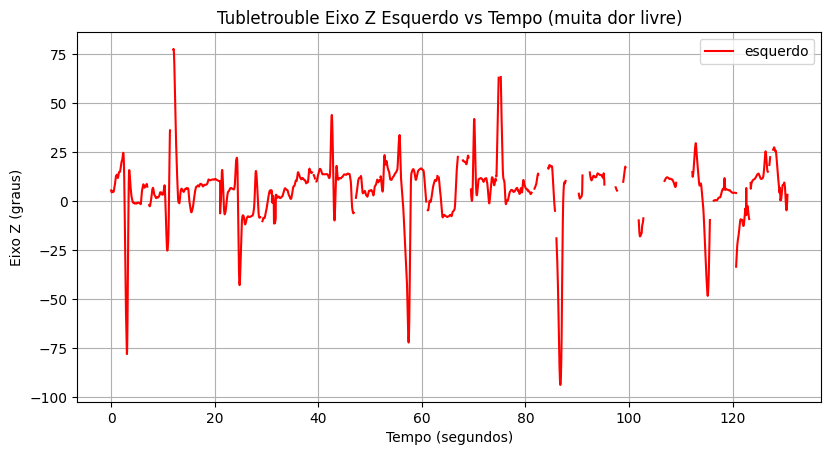

In [28]:
# plota tubetrouble na linha do tempo

tubetroubleAngulosZsemNaN = tubetroubleC3dsConcatenados.sel(channel="LShoulderAngles").sel( axis="z")

plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

tubetroubleAngulosZsemNaN.plot(label='esquerdo', color='red')
#tubetroubleAngulosYsemNaN_Right.plot(label='direito', color='red')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo Z (graus)")
plt.title("Tubletrouble Eixo Z Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

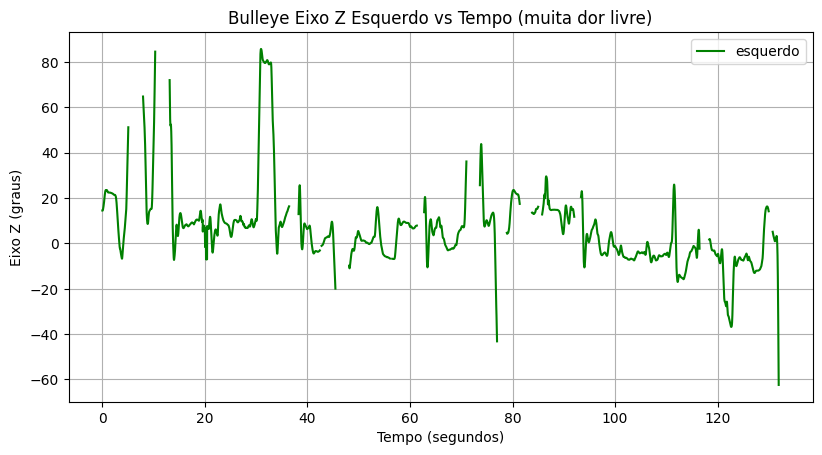

In [29]:
# plota bulleye na linha do tempo

bulleyeAngulosZsemNaN = bulleyeC3dsConcatenados.sel(channel="LShoulderAngles").sel( axis="z")

plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

bulleyeAngulosZsemNaN.plot(label='esquerdo', color='green')
#tubetroubleAngulosYsemNaN_Right.plot(label='direito', color='red')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo Z (graus)")
plt.title("Bulleye Eixo Z Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

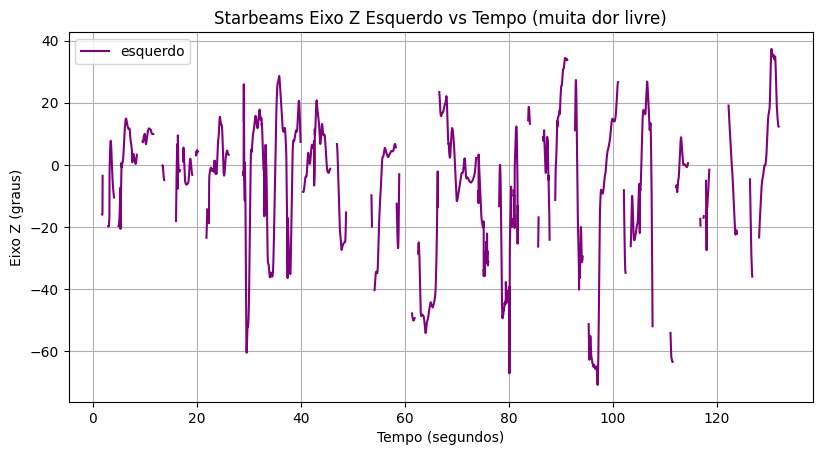

In [30]:
# plota bulleye na linha do tempo

starbeamsAngulosZsemNaN = starbeamsC3dsConcatenados.sel(channel="LShoulderAngles").sel( axis="z")

plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

starbeamsAngulosZsemNaN.plot(label='esquerdo', color='purple')
#tubetroubleAngulosYsemNaN_Right.plot(label='direito', color='red')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo Z (graus)")
plt.title("Starbeams Eixo Z Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()

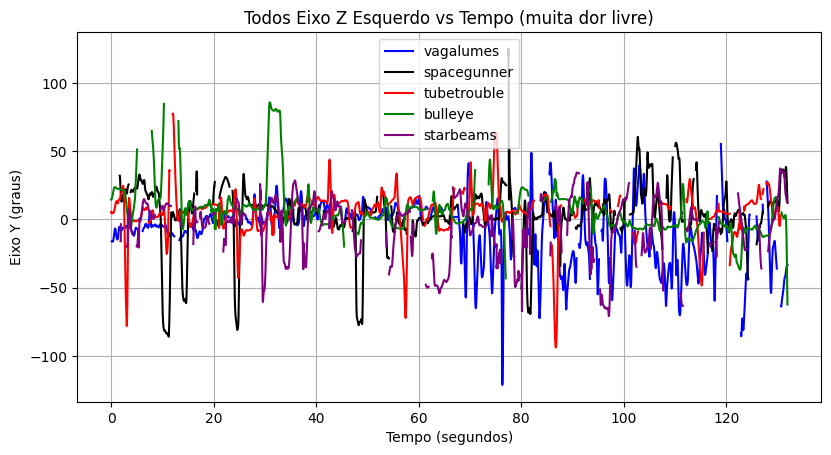

In [31]:
# plota todos na linha do tempo


plt.figure(figsize=(12*.8, 6*.8))

#markers_without_null.sel(axis='y').plot(label='eixo Y (flexao)', color='blue')       # Extract angle values
#markers_without_null.sel(axis='x').plot(label='eixo x (abducao)', color='red')       # Extract angle values
#markers_without_null.sel(axis='z').plot(label='eixo z (rotacao interna)', color='green')       # Extract angle values

vagalumesAngulosZsemNaN.plot(label='vagalumes', color='blue')
spacegunnerAngulosZsemNaN.plot(label='spacegunner', color='black')
tubetroubleAngulosZsemNaN.plot(label='tubetrouble', color='red')
bulleyeAngulosZsemNaN.plot(label='bulleye', color='green')
starbeamsAngulosZsemNaN.plot(label='starbeams', color='purple')
#tubetroubleAngulosYsemNaN_Right.plot(label='direito', color='red')

# Plotting
plt.xlabel("Tempo (segundos)")
plt.ylabel("Eixo Y (graus)")
plt.title("Todos Eixo Z Esquerdo vs Tempo (muita dor livre)")
plt.legend()
plt.grid()
plt.show()